<a href="https://colab.research.google.com/github/AndreassOlsson/faceID/blob/main/SiameseNN_fastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU memory

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import torch
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=eea04e4775c1fdbb78b5a32292842dd5f8c15d03fda53070129e9dfd7f09d521
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.0 GB  | Proc size: 254.4 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [ ]:
torch.cuda.empty_cache()

# Step 1 - The Data

## Unzipping, untaring & extracting all image files

In [ ]:
!pip install fastai==2.4
!pip install timm
from fastai.vision.all import *
import tarfile

In [ ]:
# path = "drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lfw-sub.tgz" 
# path = "drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lfw-dfun.tgz" 

# path = "drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lfw-sub-extracted.tgz" 
path = "drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lfw-dfun-extracted-nm.tgz" 

tar = tarfile.open(path)
# tarfile.open(path, 'r:gz').extractall('dataset')
tarfile.open(path, 'r:gz').extractall('dataset2')

In [ ]:
# path_orig = Path('dataset/lfw-sub-extracted/')
path_orig = Path('dataset2/dfun_e/')

people = list(path_orig.ls())
paths = list(set(filter(lambda folder: len(folder.ls())>1, people)))

In [ ]:
import itertools

def f(path):
  return get_image_files(path)

items = list(map(f, paths))
items = L(list(itertools.chain.from_iterable([[j for j in i] for i in items])))

## Label to fnames mapping

In [ ]:
def label_func(fn): return parent_label(fn)
labels = list(set(items.map(label_func)))

In [ ]:
lbl2files = {l: [f for f in items if label_func(f) == l] for l in labels}

## Create DataLoaders

The show methods in fastai all rely on some types being able to show themselves. Additionally, some transforms that need to be reversed for showing purposes (like changing a category to an index, or normalizing) have a decodes method to undo what their encodes did. In general, fastai will call those decodes method until it arrives at a type that knows how to show itself, then call the show method on this type.

In [ ]:
class SiameseImage(fastuple):
  def show(self, ctx=None, **kwargs):
    if len(self) > 2: img1, img2, similarity = self
    else: img1, img2 = self; similarity = 'Undetermined'

    if not isinstance(img1, Tensor):
      if not img2.size == img1.size: img2.resize(img1.size)
      t1, t2 = tensor(img1), tensor(img2)
      t1, t2 = t1.permute(2,0,1), t2.permute(2,0,1)
    else: t1, t2 = img1, img2
    line_divider = t1.new_zeros(t1.shape[0], t2.shape[1], 5)
    return show_image(torch.cat([t1,line_divider,t2], dim=2), title=similarity, ctx=ctx, **kwargs)


Note that we used the fastai type PILImage instead of a PIL.Image. That is to get access to fastai’s transforms. For instance, we can use Resize and ToTensor directly on our SiamesImage. Since it subclasses tuple, those transforms are dispatched and applied to the part that make sense (the PILImages, not the bool).

In [ ]:
def customSplitter(items):
  "This split works on the parent folders, person A with all its images is in either train or valid, not both"
  np.random.seed(42)
  label_idxs = np.random.permutation(range(len(labels)))
  cut = int(0.70 * len(label_idxs))
  labelSplit = (L(list(label_idxs)[:cut]), L(list(label_idxs)[cut:]))

  ds = [{l: [f for f in lbl2files[l] if label_func(f) == l] for l in L(labels)[labelSplit[i]]} for i in range(2)]
  train_dict, valid_dict = ds[0], ds[1]

  train = L(sorted({x for v in train_dict.values() for x in v}))
  valid = L(sorted({x for v in valid_dict.values() for x in v}))

  return train, valid

tr, val = customSplitter(items)

Our method of choice is to: 

Transform > TfmdLists for train & valid > DataLoaders

In the DataLoaders we need to make sure that both train & valid share the same Transform

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files, self.is_valid = files, is_valid
        self.labels = list(set(files.map(label_func)))
        self.lbl2files = {l: [f for f in lbl2files[l] if label_func(f) == l] for l in self.labels}

        if self.is_valid:
          self.valid = {f: self._draw(f) for f in self.files}
          
    def encodes(self, f):
        if self.is_valid:
          f2,same = self.valid.get(f, self._draw(f))
        else:
          f2,same = self._draw(f)
          
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        # img1, img2 = PILImage.create(tensor(Image.open(f).convert('L'))), PILImage.create(tensor(Image.open(f2).convert('L')))
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        
        if not same: cls = random.choice(L(l for l in self.labels if l != cls))

        return random.choice(self.lbl2files[cls]), same

In [ ]:
tls_train = TfmdLists(tr, SiameseTransform(tr))
tls_valid = TfmdLists(val, SiameseTransform(val, True))

dls = DataLoaders.from_dsets(tls_train, tls_valid, bs=64, after_item=[Resize(224), ToTensor], after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
# dls = DataLoaders.from_dsets(tls_train, tls_valid, bs=16, after_item=[Resize(320), ToTensor], after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
# dls = DataLoaders.from_dsets(tls_train, tls_valid, bs=6, after_item=[Resize(380), ToTensor], after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

dls.valid.after_item = dls.train.after_item
dls.valid.after_batch = dls.train.after_batch
dls = dls.cuda()

For show_batch to work we need write a custom type dispatch where x:SiameseImage

In [ ]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

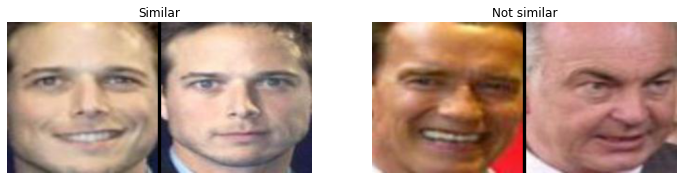

In [ ]:
dls.show_batch(max_n=2)

# Step 2 - The Model

## Create the model

### Model args

In [ ]:
class SiameseModel(Module):
  def __init__(self, encoder, head):
    self.encoder, self.head = encoder, head

  def forward(self, x1, x2):
    features = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
    return self.head(features)

In [ ]:
def siamese_splitter(model):
  return [params(model.encoder), params(model.head)]

In [ ]:
def loss_func(out, targ):
  return CrossEntropyLossFlat()(out, targ.long())

### FastAI model

For our encoder, we use the fastai function create_body. It takes an architecture and an index where to cut it. By default it will use the pretrained version of the model we pick. If we want to check where fastai usually cuts the model, we can have a look at the model_meta dictionary:

In [ ]:
model_meta[resnet50]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [ ]:
encoder = create_body(resnet50, cut=-2)
encoder[-1]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

It ends up with 512 features, so for our custom head, we will need to multiply this by 4 (i.e. 2*2): 2 because we have two images concatenated, and another 2 because of the fastai concat-pool trick (we concatenate the average pool and the max pool of the features). The create_head function will give us the head that is usually used in fastai’s transfer learning models.

We also need to define the number of outputs of our head n_out, in our case it’s 2: One for predicting both images are from the same class, and the other, to predict the contrary.

In [ ]:
head = create_head(2048*2, 2, ps=0.5)
model = SiameseModel(encoder, head)

### Timm model

In [ ]:
from fastai.vision.all import *
from fastai.vision.learner import cnn_learner, create_head, create_body, num_features_model, default_split, has_pool_type, apply_init, _update_first_layer

from torch import nn
from timm import create_model

In [ ]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise ("cut must be either integer or function")

In [ ]:
# timm_body = create_timm_body('volo_d1_224', pretrained=True)
# timm_body = create_timm_body('volo_d3_224', pretrained=True)
timm_body = create_timm_body('volo_d1_224', pretrained=True)

# timm_body = create_timm_body('tf_efficientnet_b7_ns', pretrained=True)
# timm_body = create_timm_body('resnet50d', pretrained=True)
# timm_body = create_timm_body('tf_efficientnet_b5_ns', pretrained=True)
# timm_body = create_timm_body('efficientnetv2_rw_m', pretrained=True)
# timm_body = create_timm_body('tf_efficientnetv2_s', pretrained=True)
# timm_body = create_timm_body('efficientnet_b3a', pretrained=True)

nf = num_features_model(nn.Sequential(*timm_body.children()))

timm_head = create_head(nf*2, 2, ps=0.5)

Downloading: "https://github.com/sail-sg/volo/releases/download/volo_1/d1_224_84.2.pth.tar" to /root/.cache/torch/hub/checkpoints/d1_224_84.2.pth.tar


In [ ]:
model = SiameseModel(timm_body, timm_head)

### Create Learner

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, splitter=siamese_splitter, metrics=accuracy)

## Train the model

### Find learning rate

In [ ]:
learn.freeze()

SuggestedLRs(valley=tensor(0.0017))

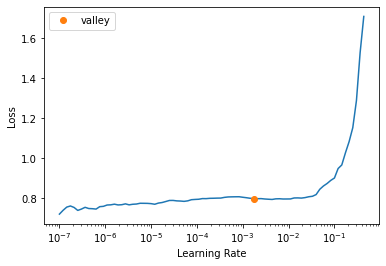

In [ ]:
learn.lr_find()

### Fit head

In [ ]:
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.755715,0.698794,0.578709,00:41
1,0.701043,0.658960,0.601745,00:44
2,0.668420,0.638026,0.633159,00:41
3,0.642125,0.627309,0.635951,00:41


### Find second learning rate

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=tensor(5.2481e-05))

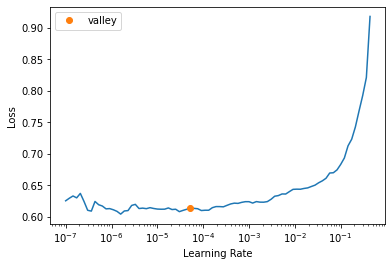

In [ ]:
learn.lr_find()

### Fit whole model

In [ ]:
learn.fit_one_cycle(4, slice(5e-7,5.2481e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.624232,0.590659,0.677076,01:23
1,0.613405,0.588075,0.677409,01:23
2,0.615066,0.586436,0.681063,01:23
3,0.617280,0.587228,0.676080,01:24


volo_d1_244, lfw_dfun_extracted_nm, 70% accuracy

### Export

In [ ]:
# learn.export('drive/MyDrive/Andreas Olsson/FastAI/faceID/models/efficientnet-b3a_lfw-sub-extracted.pkl')
# learn.export('drive/MyDrive/Andreas Olsson/FastAI/faceID/models/resnet34_lfw-sub-extracted.pkl')

# learn.export('drive/MyDrive/Andreas Olsson/FastAI/faceID/models/efficientnet-b3a_lfw-dfun-extracted.pkl')
# learn.export('drive/MyDrive/Andreas Olsson/FastAI/faceID/models/resnet34_lfw-dfun-extracted.pkl')

learn.export('drive/MyDrive/Andreas Olsson/FastAI/faceID/models/224g_volo_1d_lfw-dfun-extracted-nm.pkl')

### Making show results work

In [ ]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=3, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 4)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        probs = nn.Softmax(dim=1)(y[2][i].reshape(1,-1))[0]
        pred = np.argmax(probs)
        title = f"Actual: {['Not similar','Similar'][x[2][i].item()]} \n Prediction: {['Not similar','Similar'][pred]} \n Confidence: {format(probs[pred], '.2f')}"
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

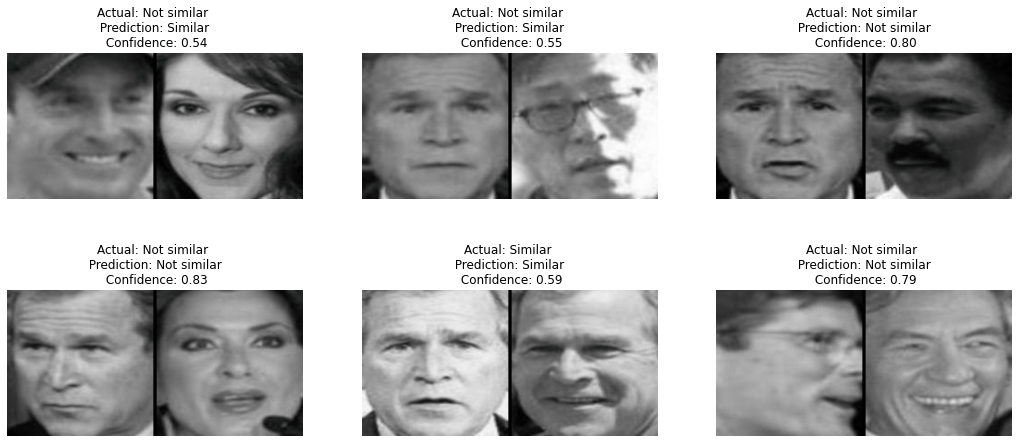

In [ ]:
learn.show_results(max_n=6)

# Step 3 - Inference

## Load learner

We need to recreate any custom code refered to by the learner:

In [ ]:
from fastai.vision.all import *

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files, self.is_valid = files, is_valid
        self.labels = list(set(files.map(label_func)))
        self.lbl2files = {l: [f for f in lbl2files[l] if label_func(f) == l] for l in self.labels}
        if self.is_valid:
          self.valid = {f: self._draw(f) for f in self.files}
          
    def encodes(self, f):
        if self.is_valid:
          f2,same = self.valid.get(f, self._draw(f))
        else:
          f2,same = self._draw(f)
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in self.labels if l != cls))
        return random.choice(self.lbl2files[cls]), same

class SiameseImage(fastuple):
  def show(self, ctx=None, **kwargs):
    if len(self) > 2: img1, img2, similarity = self
    else: img1, img2 = self; similarity = 'Undetermined'

    if not isinstance(img1, Tensor):
      if not img2.size == img1.size: img2.resize(img1.size)
      t1, t2 = tensor(img1), tensor(img2)
      t1, t2 = t1.permute(2,0,1), t2.permute(2,0,1)
    else: t1, t2 = img1, img2
    line_divider = t1.new_zeros(t1.shape[0], t2.shape[1], 5)
    return show_image(torch.cat([t1,line_divider,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

class SiameseModel(Module):
  def __init__(self, encoder, head):
    self.encoder, self.head = encoder, head

  def forward(self, x1, x2):
    features = torch.cat([self.encoder
    (x1), self.encoder(x2)], dim=1)
    return self.head(features)

def loss_func(out, targ):
  return CrossEntropyLossFlat()(out, targ.long())

def siamese_splitter(model):
  return [params(model.encoder), params(model.head)]

In [ ]:
learn = load_learner('drive/MyDrive/Andreas Olsson/FastAI/faceID_lfw-deepfunneled_model.pkl')

## Perform inference

To use learn.predict we will need to pass a SiameseImage of correct size and in tensor format. We use custom functions to make this easier:

In [ ]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False, with_return=True):
    res = self.predict(item, rm_type_tfms=rm_type_tfms, with_input=with_input)[0]
    probs = nn.Softmax(dim=1)(res.reshape(1,-1))[0]
    pred = np.argmax(probs)

    title = f"Prediction: {['Not similar','Similar'][pred]} \n Confidence: {format(probs[pred], '.2f')}"
    SiameseImage(item[0], item[1], title).show()

    if with_return:
      return probs

In [ ]:
def predict(img1, img2):
  im1 = PILImage.create(img1)
  im2 = PILImage.create(img2)
  sImg = SiameseImage(im1,im2)
  sImg = Resize(224)(sImg)
  sImg = ToTensor()(sImg)
  learn.siampredict(sImg)

In [ ]:
predict('p3.jpg','p1.jpeg')